In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


import torch
import matplotlib.pyplot as plt

from utils.augmentations import get_default_transform
from utils import creating_dataset


In [2]:
DATA_PATH = "/Users/federicoclaudi/Downloads/dataset_v2_blocks"

data_paths = dict(
    datasets=[DATA_PATH],
    hand_type = ['left', 'right'], # [left, 'right']
    human_type = ['health', 'amputant'], # [amputant, 'health']
    test_dataset_list = ['fedya_tropin_standart_elbow_left']  # don't change this !
)

# define a config object to keep track of data variables
data_config = creating_dataset.DataConfig(**data_paths)

# get transforms
p_transform = 0.1  # probability of applying the transform
transform = get_default_transform(p_transform)

# load the data
train_dataset, test_dataset = creating_dataset.get_datasets(data_config, transform=transform)


Getting val datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Getting train datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Number of moves: 70 | Dataset: valery_first_standart_elbow_left
Reorder this dataset valery_first_standart_elbow_left True
Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
Number of moves: 72 | Dataset: anna_makarova_standart_elbow_left
Reorder this dataset anna_makarova_standart_elbow_left True
Number of moves: 62 | Dataset: artem_snailbox_standart_elbow_left
Reorder this dataset artem_snailbox_standart_elbow_left True
Number of moves: 144 | Dataset: matthew_antonov_standart_elbow_left
Reorder this dataset matthew_antonov_standart_elbow_left True
Number of moves: 144 | Dataset: misha_korobok_standart_elbow_left
Reorder this da

In [3]:
x, y = train_dataset[0]

print(x.shape, y.shape, len(train_dataset), len(test_dataset))

(8, 256) (20, 32) 99990 792


## Train MLP

In [43]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = self.layers(x)
        return x[::data_config.down_sample_target, :]
    


In [56]:
n_epochs = 1
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_inputs, n_outputs = x.shape[0], y.shape[0]
n_hidden = 512


model = MLP(n_inputs, n_hidden, n_outputs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

train_Xs = [torch.tensor(x, device=device) for x, _ in train_dataset]
train_Ys = [torch.tensor(y, device=device) for _, y in train_dataset]


for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    epoch_loss = 0
    for X,Y in zip(train_Xs, train_Ys):
        Y_hat = model(X.T).T

        loss = criterion(Y_hat, Y)
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_dataset):.4f}")

    

Epoch 1 Loss: 0.2714


Plot predictions & evaluate

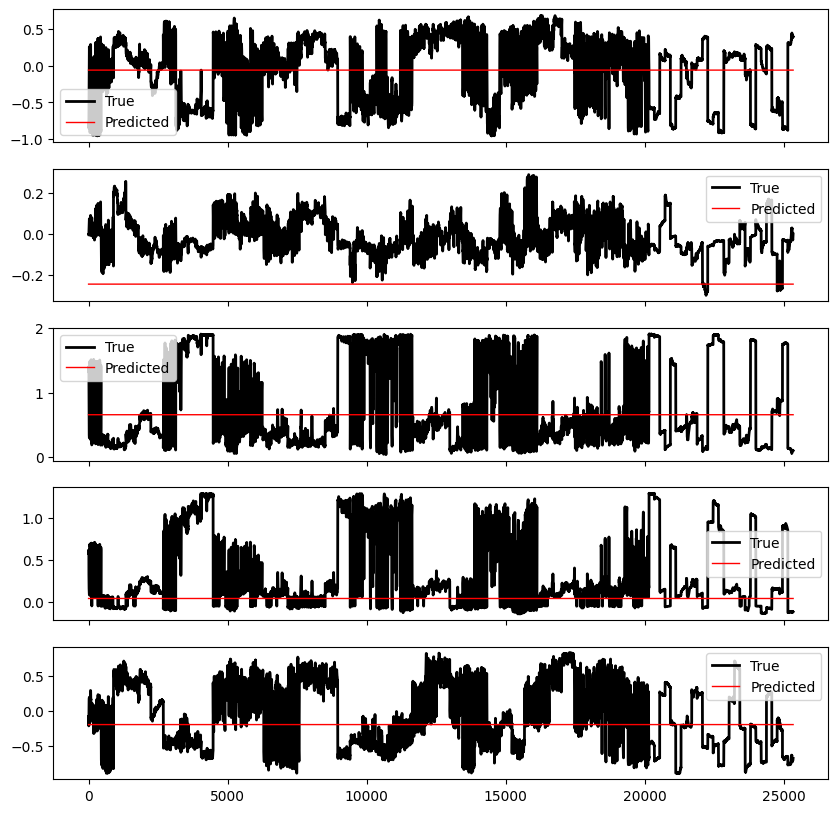

In [57]:
import numpy as np

X = np.concatenate([x for x, _ in test_dataset], axis=1)
Y = np.concatenate([y for _, y in test_dataset], axis=1)

Y_hat = model(torch.tensor(X.T).to(device)).detach().cpu().numpy().T

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label="Predicted", lw=1, color='r')

    ax.legend()


In [54]:
# get MSE on test dataset
test_loss = 0
model.eval()
for X,Y in test_dataset:
    X, Y = torch.tensor(X.T).to(device), torch.tensor(Y).to(device)
    Y_hat = model(X).T

    loss = criterion(Y_hat, Y)
    test_loss += loss.item()

print(f"Test Loss: {test_loss:.6f}")

Test Loss: 205.860719


# Train OMEN

In [30]:
from abcidatasets import Dataset, DatasetVariable
from omen import OMEN
import pandas as pd
import numpy as np
import sys
from loguru import logger


logger.remove()
logger.add(sys.stderr, level=1)

2

Generate session

In [18]:
train_Xs = np.concatenate([x[:, ::data_config.down_sample_target] for x, _ in train_dataset], axis=1)
train_Ys = np.concatenate([y for _, y in train_dataset], axis=1)

n_inputs, n_outputs = train_Xs.shape[0], train_Ys.shape[0]

print(
    train_Xs.shape, train_Ys.shape
)


(8, 3199680) (20, 3199680)


In [23]:
data = {}
for i in range(n_inputs):
    data[f"myo_{i}"] = train_Xs[i]
for i in range(n_outputs):
    data[f"target_{i}"] = train_Ys[i]
data = pd.DataFrame(data)
data['time'] = np.arange(data.shape[0])

print(data.shape)
data.head(3)

(3199680, 29)


,myo_0,myo_1,myo_2,myo_3,myo_4,myo_5,myo_6,myo_7,target_0,target_1,...,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,time
0,-1.000000,-0.20000,-0.050980,-0.003922,0.003922,0.090196,0.239216,-0.843137,0.100278,-0.082439,...,0.622547,0.395041,0.009854,0.405994,0.143641,0.188605,-0.197526,0.273472,0.131866,0
1,0.066667,0.85098,0.372549,0.239216,0.121569,0.082353,0.098039,0.717647,0.094921,-0.083631,...,0.639360,0.412809,0.011969,0.413050,0.147554,0.189739,-0.195720,0.277672,0.135523,1
2,1.000000,1.00000,-0.019608,-0.207843,-0.082353,0.176471,0.058824,-0.317647,0.086049,-0.084006,...,0.653219,0.421997,0.011857,0.413757,0.149662,0.190361,-0.193748,0.281601,0.138642,2


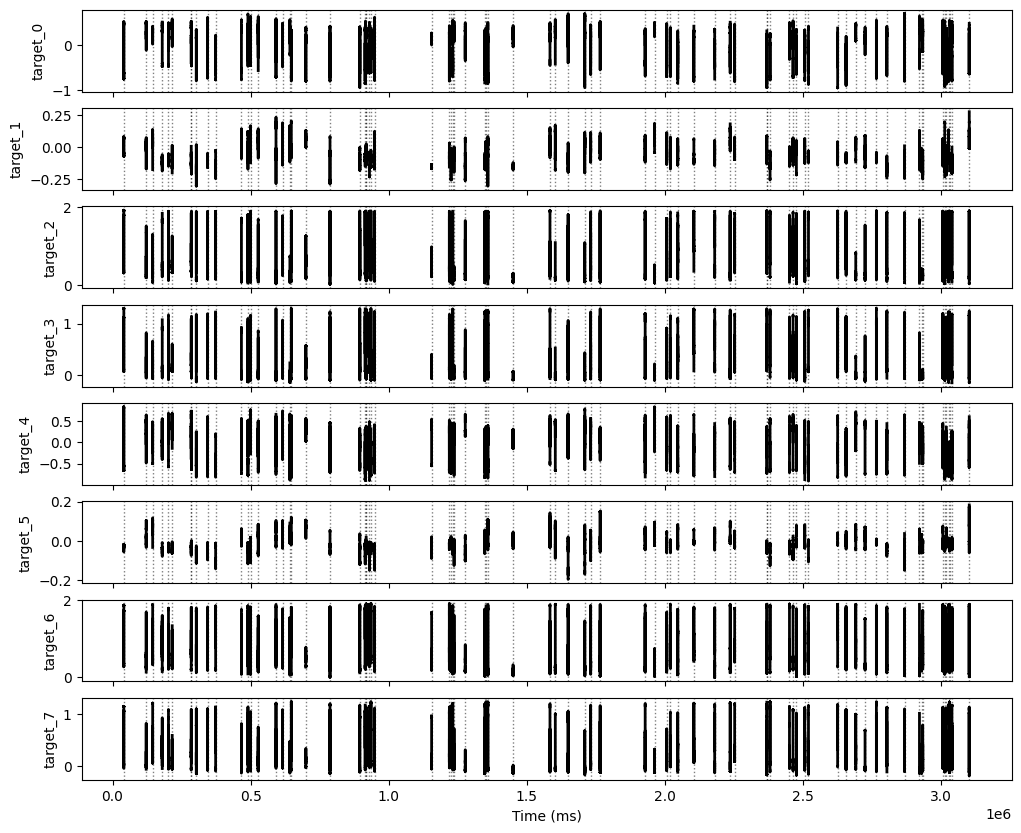

In [28]:
variables = [DatasetVariable(f'target_{i}', 'hand', False) for i in range(n_outputs)]
ds =  Dataset('hand', '', -1, 20, 1, variables, [])

sess = ds.session_from_df(
    data, 'hand', 'session', variables, 20, unit_prefix='myo_', trial_duration_seconds=2
)
sess.train_trials = sess.all_trials  # we're only using the training set to create the session so this is ok
ds.sessions.append(sess)

sess.visualize(max_n_trials=25);

Train OMEN

2024-07-29 15:49:28.848 | DEBUG_LOW | omen.omen:build:67 - Building OMEN - encoder input dimension: 8
2024-07-29 15:49:28.864 | DEBUG    | omen.omen:fit_session:249 - Fitting OMEN with a single session: session
2024-07-29 15:49:29.186 | DEBUG_LOW | omen.lookup.lut:on_fit_start:90 - Fitting Y scalers on 3199600 samples - 20 dimensions | 1 sessions
2024-07-29 15:49:29.302 | DEBUG_LOW | omen.lookup.session:populate:93 - Populating session session lookup.
2024-07-29 15:51:28.893 | DEBUG    | omen.train.base_trainer:__init__:51 - 
Trainer SingleSessionTrainer created with 
LUT(n sessions: 1, embedding size: 256)
	* session 
and
Portent
	Encoder: tCNN: 8 |>  |> 32 -  tanh, 1 kernels, kernel_size: 1
	Heads:
		0: MLP: 32 |> 48 - linear
		1: MLP: 32 |> 48 - linear
		2: MLP: 32 |> 48 - linear
		3: MLP: 32 |> 48 - linear
		4: MLP: 32 |> 48 - linear
		5: MLP: 32 |> 48 - linear
		6: MLP: 32 |> 48 - linear
		7: MLP: 32 |> 48 - linear
		8: MLP: 32 |> 48 - linear
		9: MLP: 32 |> 48 - linear
		10: MLP:

Output()

2024-07-29 15:52:06.312 | TENSORS  | omen.debug:log_tensor:33 - tCNN input: Tensor: torch.Size([25, 127984, 8]) - device: cpu


2024-07-29 15:52:06.668 | TENSORS  | omen.debug:log_tensor:33 - tCNN conv1: Tensor: torch.Size([25, 127984, 8]) - device: cpu


2024-07-29 15:52:07.535 | TENSORS  | omen.debug:log_tensor:33 - tCNN output: Tensor: torch.Size([25, 127984, 32]) - device: cpu


2024-07-29 15:59:03.178 | DEBUG_LOW | omen.train.base_trainer:train:180 - Training interrupted
2024-07-29 15:59:03.565 | GPU      | omen.train.device_manager:unload:82 - Unloading all models
2024-07-29 15:59:03.575 | REFINE   | omen.omen:refine_cans:95 - Refining CAN hyperparameters
2024-07-29 15:59:03.577 | REFINE   | omen.omen:refine_cans:105 - session 1/1
2024-07-29 15:59:05.789 | REFINE   | omen.omen:refine_cans:116 -   CAN 1/20
2024-07-29 16:02:26.276 | REFINE   | omen.can:refine:257 - refined beta - 1.000 -> 2.000 || loss: 0.03155 -> 0.03133
2024-07-29 16:05:35.267 | REFINE   | omen.can:refine:257 - refined sigma - 0.250 -> 0.125 || loss: 0.03133 -> 0.02762
2024-07-29 16:05:35.268 | REFINE   | omen.omen:refine_cans:116 -   CAN 2/20
2024-07-29 16:08:38.574 | REFINE   | omen.can:refine:257 - refined beta - 1.000 -> 0.667 || loss: 0.00959 -> 0.00949
2024-07-29 16:11:39.777 | REFINE   | omen.can:refine:257 - refined sigma - 0.250 -> 0.500 || loss: 0.00949 -> 0.00620
2024-07-29 16:11:

KeyboardInterrupt: 

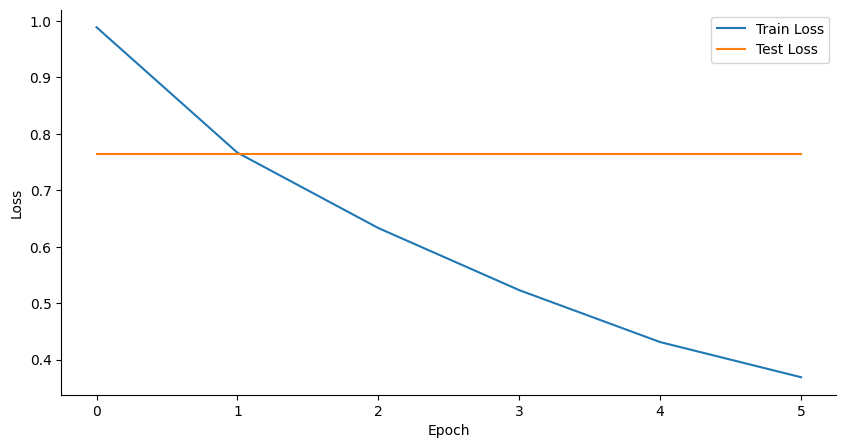

In [31]:
omen_config = dict(
    activation= 'tanh',
    beta= 1.0,
    embedding_dim= 32,
    head_n_layers= -1,
    input_sigma= 0.25,
    kernel_size= 1,
    lr= 0.0075,
    n_epochs= 2_000,
    n_hidden= 24,
    n_kernels= 1,
    n_layers= -1,
    sigma= 0.25,
)


betas = [4, 8, 8, 4, 4, 4, 4, 4]
sigmas = [1, 1, 1, 1, 0.5, 1, 1, 0.5]

# create and fit
omen = OMEN.from_config(omen_config)
omen.fit_session(
    sess, plot_history=True, verbose=True, should_refine=True
)

# refine CAN hps
# for i, (beta, sigma) in enumerate(zip(betas, sigmas)):
#     omen.cans[i].initial_params = {'beta': beta, 'sigma': sigma}
#     omen.cans[i].cell.tau = 1.2

# omen.refine_cans(verbose=True)
omen

In [32]:
for tset in ('test', 'train', 'validation'):
    omen.predict_session(sess, tset)

sess.visualize(max_n_trials=50);

2024-07-29 16:57:50.203 | DEBUG_LOW | omen.omen:predict_session:264 - Predicting session session - test


KeyboardInterrupt: 